In [2]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import hstack

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [3]:
# Load the data and store it as a pandas data frame
transactions = pd.read_csv('SAKI Exercise 1 - Transaction Classification - Data Set.csv', sep=';')

# Quick glance at the data set
Only a quick glance at the whole data set to get a feeling about the data structures. A more detailed analysis will be done on the training set. 

In [4]:
transactions.head()

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


In [5]:
transactions['label'].value_counts()

leisure             65
standardOfLiving    47
finance             33
living              26
private             21
income              17
Name: label, dtype: int64

In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         209 non-null    int64  
 1   Auftragskonto                      168 non-null    float64
 2   Buchungstag                        209 non-null    object 
 3   Valutadatum                        209 non-null    object 
 4   Buchungstext                       209 non-null    object 
 5   Verwendungszweck                   209 non-null    object 
 6   Beguenstigter/Zahlungspflichtiger  209 non-null    object 
 7   Kontonummer                        208 non-null    object 
 8   BLZ                                208 non-null    object 
 9   Betrag                             209 non-null    object 
 10  Waehrung                           209 non-null    object 
 11  label                              209 non-null    object 

## Train and Test Data Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
            transactions.drop('label', axis=1),      # features
            transactions['label'],                   # labels
            test_size = 0.2,                         # Split into 80% train and 20% test data
            random_state = 42,                       # Makes sure that in every run the same test data is used 
            shuffle = True,                          # Shuffles the data set before splitting
            # Does not split randomly but preserves the same distribtution
            # (of labels) in the test and the train data set
            stratify = transactions['label'])

# Detailed Analysis
In the following section we examine each feature/column

In [18]:
for col_nr, col_name in enumerate(list(transactions.columns)):
    print(f'#{col_nr+1:<2}:  {col_name}')

#1 :  Unnamed: 0
#2 :  Auftragskonto
#3 :  Buchungstag
#4 :  Valutadatum
#5 :  Buchungstext
#6 :  Verwendungszweck
#7 :  Beguenstigter/Zahlungspflichtiger
#8 :  Kontonummer
#9 :  BLZ
#10:  Betrag
#11:  Waehrung
#12:  label


### #1 Unnamed: 0

In [194]:
X_train[X_train.index != X_train['Unnamed: 0']]

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung


This aligns with the assumption that the column 'Unnamed: 0' serves as an index/id for the individual transactions. As this is not a feature of the transaction itself it should not be selected as a feature.

### #2 Auftragskonto

In [10]:
X_train['Auftragskonto'].value_counts(dropna=False)                   

89990210.0    97
89990201.0    36
NaN           34
Name: Auftragskonto, dtype: int64

There are only two accounts and NaN values. These values should not be treated as if they have order (89990210.0 > 89990201.0 ?) and NaN values should be considered. We use one-hot enoding to solve both problems.

### #3 Buchungstag & #4 Valutadatum

A first glance at the data already gave the impression that both dates are identical.

In [191]:
X_train[X_train['Buchungstag'] != X_train['Valutadatum']]

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung


By examining our training set we can confirm this.
Of course it may differ on unseen data but since there is no hint 
in the training data we only take one date into consideration.
Here 'Buchungstag' is the better feature because it is more related to the user side of the transaction, while 'Valutadatum' depends on the process of the bank and is not linked to the type of transaction.

In [193]:
X_train['Buchungstag']

150    25.01.2016
96     02.03.2016
199    02.03.2016
68     31.03.2016
156    20.01.2016
          ...    
106    29.02.2016
14     08.06.2016
92     04.03.2016
179    01.06.2016
102    29.02.2016
Name: Buchungstag, Length: 167, dtype: object

In [19]:
dates = pd.to_datetime(X_train['Buchungstag'], format = '%d.%m.%Y', errors = 'raise')
print('Years that occur in the data:')
print(np.sort(dates.apply(lambda x : x.year).unique()))
print('Months that occur in the data:')
print(np.sort(dates.apply(lambda x : x.month).unique()))
print('Days that occur in the data:')
print(np.sort(dates.apply(lambda x : x.day).unique()))
print('Weekdays that occur in the data:')
print(np.sort(dates.apply(lambda x : x.isoweekday()).unique()))

Years that occur in the data:
[2016]
Months that occur in the data:
[1 2 3 4 5 6 7]
Days that occur in the data:
[ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 18 19 20 21 22 23 24 25 26
 27 28 29 30 31]
Weekdays that occur in the data:
[1 2 3 4 5]


To use the date as a feature we consider the following: 

- Weekday
- Day of month
    
We do not consider:

- Year: The data set is based on 2016 and we want predictions for future years as well
- Month: The data set only contains data up to July


### #5 Buchungstext

In [25]:
X_train['Buchungstext'].value_counts()

Lastschrift (Einzugsermächtigung)    77
Geldanlage                           14
Lebensmittel / Getraenke             13
Lohn / Gehalt                        11
Dauerauftrag                          9
Miete                                 9
Drogerie                              9
Mieteinnahmen                         7
Euro-Überweisung                      7
Bargeld                               6
Gehalt/Rente                          3
Abschluss                             1
Spontanausgabe                        1
Name: Buchungstext, dtype: int64

The next is pretty clean. We only discard special characters and treat everything lower case

### #6 Verwendungszweck

In [26]:
X_train['Verwendungszweck'].value_counts()

Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: Notprovided Kundenreferenz: Nsct1603300013660000000000000000001 Gutschrift    11
Ccbade31Xxx De71310108339900123456 Sparen End-To-End-Ref.: Notprovided Dauerauftrag Dauerauftrag                            10
Byladem1Sbt De12773501123456789889 Miete Beuthener Str. 25 End-To-End-Ref.: Notprovided Dauerauftrag Dauerauftrag            9
Mietzuschuss End-To-End-Ref.: Notprovided Kundenreferenz: Nsct1603080001510000000000000000006 Gutschrift                     7
2831 Edeka Neubauer Nuernb.//Nuernb 2016-05-04T17:54:45 Kfn 9 Vj 1612 Lastschrift                                            4
                                                                                                                            ..
Interne Umbuchung                                                                                                            1
Bears + Friends Gmb//Pulsnitz/De 20 16-01-02T14:18:06 Folgenr.000 Verfa Lld.2016-12                            

In [27]:
X_train['Verwendungszweck'].replace(to_replace ='\d', value = ' ', inplace=False, regex = True)

201    Byladem Sbt De                     Miete Beuth...
167         Edeka Neubauer Nuernb.//Nuernb     -  -  ...
80     Visa           -   -       ,  Eur ,           ...
23     Mietzuschuss End-To-End-Ref.: Notprovided Kund...
139       -       -        Amazon .Mktplce Eu-De     ...
                             ...                        
202    Dm Fil.     H:     //Nuernberg/De      -  -  T...
67                                     Bp          /    
21     Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...
60     Tk Maxx Nuernberg//Nuernberg/De      -  -  T  ...
121    Visa                   ,  Eur ,             . ...
Name: Verwendungszweck, Length: 167, dtype: object

In its raw format the feature is pretty unstructured. We discard number because they are mostly related to the bank account number, credit card number, or to the date/time.

### #7 Beguenstigter/Zahlungspflichtiger

In [29]:
X_train['Beguenstigter/Zahlungspflichtiger'].value_counts()

Adorsys GmbH & Co. KG             14
Kartenzahlung                     13
Bankhaus August Lenz Atm          11
Dm Drogeriemarkt Sagt Danke       10
Michael Koffer                    10
Amazon De Marketplace              9
Georg Tasche                       9
Rewe Nuernberg Aeu                 8
Isabel Anna                        7
Bargeld                            6
Anna Fein                          6
Lucas Fein                         4
Christina Jung                     4
Amazon Payments Europe S.C.A.      4
Vag                                4
Amazon Eu                          4
Aramark Gmbh I.Hs. Teambank        3
1U1 Telecom Gmbh                   3
Stromio Gmbh                       2
Esso Deutschland Gmbh              2
Tk Maxx Nürnberg                   2
Anna Fein, Lucas Fein              2
E Wie Einfach Gmbh                 2
Lastschrift Aus Kartenzahlung      1
Fuerthermare                       1
N-Style                            1
Cafe Seon Dankt                    1
C

In this column the text is already pretty clean. As with all text fields we consider everything lower case and discard special characters.

### #5 + #6 + #7

Since all of these fields share a common vocabulary we use a bag of words approach that counts the words separatly for each column but uses a shared vocabulary across the columns.

### #8 Kontonummer

In [38]:
# Fraction of how many transactions can be accounted to the 5 accounts with the most transactions.
print(X_train['Kontonummer'].value_counts()[:5].sum() / len(X_train['Kontonummer']))
X_train['Kontonummer'].value_counts()[:5]

0.4251497005988024


922904916                 28
9736000780                13
7807800780                11
DE69790800529736000780    10
7755566780                 9
Name: Kontonummer, dtype: int64

In [46]:
# All transactions have the same structure and are labeled 'leisure'
#X_train[X_train['Kontonummer'] == '922904916'] 
#y_train[X_train['Kontonummer'] == '922904916']

### #9 BLZ

In [39]:
# Fraction of how many transactions can be accounted to the 5 accounts with the most transactions.
print(X_train['BLZ'].value_counts()[:5].sum() / len(X_train['BLZ']))
X_train['BLZ'].value_counts()[:5]

0.6287425149700598


25190001       39
76030080       28
VOHADE2HXXX    20
DRESDEFF790    10
ESSEDE5F        8
Name: BLZ, dtype: int64

### #8 + #9

'Kontonummer' and 'BLZ' will not be considered in the classifcation regardless of how they perform.
Around 50 percent (0.425 and 0.628) of the transactions are associated with 5 accounts.
In the case of '922904916' all 28 transactions are labled 'leisure'.
While they have the same structure which may be used for training. The algorihm should not associate specific account numbers with lables. 

### #10 Betrag

The 'Betrag' column contains entries with both a comma and a point as decimal separators.

In [21]:
betrag = pd.to_numeric(X_train['Betrag'].str.replace(',', '.'))
betrag.describe()

count     167.000000
mean       52.811976
std       619.004321
min     -1000.000000
25%      -100.000000
50%       -28.850000
75%       -12.980000
max      2000.000000
Name: Betrag, dtype: float64

In almost all cases feature scaling enhances the training procedure. Two common scalings are min-mix scaling/normalization and standardization.

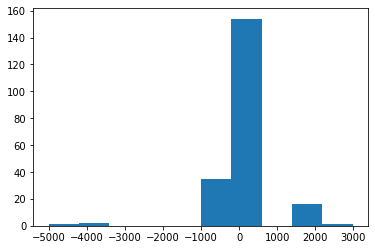

In [265]:
plt.hist(betrag)
plt.show()

Since we have quite some outliers we will use standardization, which is not so much affected by outliers as normalization is.

### #11 Waehrung

In [23]:
X_train[X_train['Waehrung'] != 'EUR']

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung


Every entry has the same value which means it adds no valuable information.
In general the currency could be a good feature but since all the entries are in 'EUR' it will not be considered.

---

The actual transformations of the above insights are implemented in Transformers such that they can be integrated in a pipeline approach.

## Transformers

In [48]:
class CrossColumnCountVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self._vec = CountVectorizer()
    
    def fit(self, X, y=None):
        words = pd.concat([X.loc[:, col] for col in X.columns])
        self._vec.fit(words)
        return self
    
    def transform(self, X, y=None):
        transformed_cols = [self._vec.transform(X.loc[:, col]) for col in X.columns]
        stacked_vectors = hstack(transformed_cols)
        return stacked_vectors
                                 
    def get_feature_names(self):
        return self._vec.get_feature_names()

In [49]:
class DenseTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.todense()

In [50]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_selection=None):
        self.feature_selection = feature_selection
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.feature_selection:
            return X[self.feature_selection]
        else:
            return X

In [51]:
class BasicPreprocessor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_cleaned = X.copy()
        X_cleaned['Auftragskonto'].fillna(0, inplace=True)
        X_cleaned['Betrag'] = X_cleaned['Betrag'].str.replace(',', '.')
        X_cleaned['Betrag'] = pd.to_numeric(X_cleaned['Betrag'], errors='raise')
        X_cleaned['Verwendungszweck'].replace(to_replace ='\d', value = ' ', inplace=True, regex = True)
        return X_cleaned 

In [52]:
class DateEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dates = pd.to_datetime(X.squeeze(), format = '%d.%m.%Y', errors = 'raise')
        days = dates.apply(lambda d: d.day).values.reshape(-1,1)
        weekdays = dates.apply(lambda d: d.isoweekday()).values.reshape(-1,1)
        return np.hstack([days, weekdays])

# Model / Pipeline

In [53]:
selected_features = ['Auftragskonto',
                     'Buchungstag',
                     'Betrag', 
                     'Buchungstext', 
                     'Beguenstigter/Zahlungspflichtiger', 
                     'Verwendungszweck'
                    ]

CATEGORICAL_ATTRIBUTES = ['Auftragskonto']
NUMERICAL_ATTRIBUTES = ['Betrag']
DATE_ATTRIBUTES = ['Buchungstag']
TEXT_ATTRIBUTES = ['Buchungstext', 'Beguenstigter/Zahlungspflichtiger', 'Verwendungszweck']

numerical_pipleline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('standardizer', StandardScaler())
])

model = Pipeline([
    ('ColumnSelector',  ColumnSelector(selected_features)),
    ('BasicPreprocessing', BasicPreprocessor()),
    ('ColumnTransformer', ColumnTransformer([
        ('numerical_pipeline', numerical_pipleline, NUMERICAL_ATTRIBUTES),
        ('date_encoder', DateEncoder(), DATE_ATTRIBUTES),
        ('vectorizer', CrossColumnCountVectorizer(), TEXT_ATTRIBUTES),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_ATTRIBUTES)
    ], remainder='drop')),
    
    # CrossColumnCountVectorizer returns a sparse matrix
    # but GaussianNB requires a dense matrix.
    ('to_dense', DenseTransformer()),
    
    # For this problem we use the Gaussian Naive Bayes algorithm
    ('NaiveBayesModel', GaussianNB())
])

In [54]:
scores = cross_val_score(model, 
                         X_train, 
                         y_train,
                         scoring='accuracy',
                         cv=KFold(5, shuffle=True))
print(scores)
print(scores.mean())

[0.88235294 0.91176471 0.84848485 0.87878788 0.90909091]
0.886096256684492


In [55]:
model.fit(X_train, y_train)

Pipeline(steps=[('ColumnSelector',
                 ColumnSelector(feature_selection=['Auftragskonto',
                                                   'Buchungstag', 'Betrag',
                                                   'Buchungstext',
                                                   'Beguenstigter/Zahlungspflichtiger',
                                                   'Verwendungszweck'])),
                ('BasicPreprocessing', BasicPreprocessor()),
                ('ColumnTransformer',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='m...
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['Betrag']),
             

# Evaluation

In [61]:
print("Evaluation on the training data set:")
print(classification_report(y_train, model.predict(X_train)))

Evaluation on the training data set:
                  precision    recall  f1-score   support

         finance       1.00      1.00      1.00        26
          income       1.00      1.00      1.00        14
         leisure       1.00      1.00      1.00        52
          living       1.00      1.00      1.00        21
         private       1.00      1.00      1.00        17
standardOfLiving       1.00      1.00      1.00        37

        accuracy                           1.00       167
       macro avg       1.00      1.00      1.00       167
    weighted avg       1.00      1.00      1.00       167



In [64]:
print("Evaluation on the test data set:")
print(classification_report(y_test, model.predict(X_test)))

Evaluation on the test data set:
                  precision    recall  f1-score   support

         finance       1.00      1.00      1.00         7
          income       1.00      1.00      1.00         3
         leisure       0.93      1.00      0.96        13
          living       1.00      0.80      0.89         5
         private       1.00      1.00      1.00         4
standardOfLiving       0.90      0.90      0.90        10

        accuracy                           0.95        42
       macro avg       0.97      0.95      0.96        42
    weighted avg       0.95      0.95      0.95        42

